# Brief Description of the problem:

The main goal of this work is to recognize objects from a number of visual object classes through the generation of a visually segmented picture of the input image. It is  a supervised learning learning problem in that a training set of labelled images is provided. The twenty object classes that have been selected are:

- Person: person
- Animal: bird, cat, cow, dog, horse, sheep
- Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
- Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor

In total, we have 21 classes including the background null class.

__Segmentation__: Generating pixel-wise segmentations giving the class of the object visible at each pixel, or "background" otherwise.

![](https://drive.google.com/uc?id=1e9LTrcD1kS9pPHAu_EKzgVHXUz9A-uPn)

Simply put, our goal is to take an RGB color image (height×width×3) and output a segmentation map (height×width×1) where each pixel contains a class label represented as an integer. The following is a nice illustration of a segmentation problem:

![](https://drive.google.com/uc?id=1QpXZwr0l178728uSlOYDc68LJ9jh5vWN)

- __Note__: In our problem, the labels are also images

- We will work on the __PASCAL VOC 2012__ data obtained from the following reference: \
@misc{pascal-voc-2012,
	author = "Everingham, M. and Van~Gool, L. and Williams, C. K. I. and Winn, J. and Zisserman, A.",
	title = "The {PASCAL} {V}isual {O}bject {C}lasses {C}hallenge 2012 {(VOC2012)} {R}esults",
	howpublished = "http://www.pascal-network.org/challenges/VOC/voc2012/workshop/index.html"}

# Importing necessary libraries:

In [0]:
import cv2
import numpy as np
from PIL import Image
import h5py
import os
import random
import threading
import queue
import matplotlib.pyplot as plt

## Importing the data:

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
root_path = "/content/drive/My Drive/VOC2012"    # Path containing the data

# Pre-processing:

In [0]:
class VOC2012:
    def __init__(self, root_path='/content/drive/My Drive/VOC2012', image_size=(224, 224), resize_method='resize'):
        '''
        This function allows for the creation of a VOC2012 object containing the dataset with relevant functions
        Args:
            root_path: the Pascal VOC 2012 folder path
            image_size: resize all images and labels into this size
        '''
        self.root_path = root_path
        self.resize_method = resize_method

        if root_path[len(root_path) - 1] != '/' and root_path[len(root_path) - 1] != '\\':
            self.root_path += '/'
        self.train_names_path = self.root_path + 'ImageSets/Segmentation/train.txt'
        self.val_names_path = self.root_path + 'ImageSets/Segmentation/val.txt'
        self.image_path = self.root_path + 'JPEGImages/'
        self.label_path = self.root_path + 'SegmentationClass/'
        self.image_size = image_size
        if os.path.isfile(self.train_names_path):
            self.read_train_names()
        if os.path.isfile(self.val_names_path):
            self.read_val_names()

    def read_train_names(self):
        '''
        Read the filenames of training images and labels into self.train_list
        '''
        self.train_names = []
        f = open(self.train_names_path, 'r')
        line = None
        while 1:
            line = f.readline().replace('\n', '')
            if line is None or len(line) == 0:
                break
            self.train_names.append(line)
        f.close()

    def read_val_names(self):
        '''
        Read the filenames of validation images and labels into self.val_list
        '''
        self.val_names = []
        f = open(self.val_names_path, 'r')
        line = None
        while 1:
            line = f.readline().replace('\n', '')
            if line is None or len(line) == 0:
                break
            self.val_names.append(line)
        f.close()
        

    def get_train(self):
        '''
        Returns a "tuple" of lists containg all of the training images & labels respectively ... each element in each of the lists is a 224x224x3 numpy array representing an image.
        '''
        batch_images = []
        batch_labels = []

        for i in range(int(len(self.train_names))):
            image = cv2.imread(self.image_path + self.train_names[i] + '.jpg')
            if self.image_size:
                image = cv2.resize(image, self.image_size)
            label = np.array(Image.open(self.label_path + self.train_names[i] + '.png'))
            label[label > 20] = 0
            if self.image_size:
                label = cv2.resize(label, self.image_size, interpolation=cv2.INTER_NEAREST)
            batch_images.append(image)
            batch_labels.append(label)

        return np.array(batch_images), np.array(batch_labels)

    def get_val(self):
        '''
        Returns a "tuple" of lists containg all of the validation images & labels respectively ... each element in each of the lists is a 224x224x3 numpy array representing an image.
        '''        
        batch_images = []
        batch_labels = []

        for i in range(int(len(self.val_names))):
            image = cv2.imread(self.image_path + self.val_names[i] + '.jpg')
            if self.image_size:
                image = cv2.resize(image, self.image_size)
            label = np.array(Image.open(self.label_path + self.val_names[i] + '.png'))
            label[label > 20] = 0
            if self.image_size:
                label = cv2.resize(label, self.image_size, interpolation=cv2.INTER_NEAREST)
            batch_images.append(image)
            batch_labels.append(label)
        return np.array(batch_images), np.array(batch_labels)


    def read_all_data_and_save(self, train_data_save_path='./voc2012_train.h5', val_data_save_path='./voc2012_val.h5'):
        '''
        Read training and validation data and save them into two .h5 files.
        Args:
            train_data_save_path:The path you want to save training data into.
            val_data_save_path:The path you want to save validation data into.
        '''
        self.read_train_images()
        self.read_train_labels()
        self.read_val_images()
        self.read_val_labels()
        self.save_train_data(train_data_save_path)
        self.save_val_data(val_data_save_path)

    def save_train_data(self, path='./voc2012_train.h5'):
        '''
        save training images and labels into path in the form of .h5
        Args:
            path:The path you want to save train data into.It must be xxx.h5
        '''
        save_h5(path, self.train_images, self.train_labels)

    def save_val_data(self, path='./voc2012_val.h5'):
        '''
        save validation images and labels into path in the form of .h5
        Args:
            path:The path you want to save train data into.It must be xxx.h5
        '''
        save_h5(path, self.val_images, self.val_labels)

    def load_all_data(self, train_data_load_path='./voc2012_train.h5', val_data_load_path='./voc2012_val.h5'):
        '''
        Load training and validation data from .h5 files
        Args:
            train_data_load_path:The training data .h5 file path.
            val_data_load_path:The validation data .h5 file path.
        '''
        self.load_train_data(train_data_load_path)
        self.load_val_data(val_data_load_path)

    def read_train_images(self):
        '''
        Read training images into self.train_images
        If you haven't called self.read_train_list(), it will call first
        After reading images, it will resize them
        '''
        self.train_images = []
        if hasattr(self, 'train_list') == False:
            self.read_train_list()
        for filename in self.train_list:
            image = cv2.imread(self.image_path + filename + '.jpg')
            if self.resize_method == 'resize':
                image = cv2.resize(image, self.image_size)
            elif self.resize_method == 'pad':
                height = np.shape(image)[0]
                width = np.shape(image)[1]
                image = cv2.copyMakeBorder(image, 0, 500 - height, 0, 500 - width, cv2.BORDER_CONSTANT, value=0)
            self.train_images.append(image)
            if len(self.train_images) % 100 == 0:
                print('Reading train images', len(self.train_images), '/', len(self.train_list))

    def read_train_labels(self):
        '''
        Read training labels into self.train_labels
        If you haven't called self.read_train_list(), it will call first
        After reading labels, it will resize them
        Note:image[image > 20] = 0 will remove all white borders in original labels
        '''
        self.train_labels = []
        if hasattr(self, 'train_list') == False:
            self.read_train_list()
        for filename in self.train_list:
            image = Image.open(self.label_path + filename + '.png')
            image = np.array(image)
            image[image > 20] = 0
            if self.resize_method == 'resize':
                image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_NEAREST)
            elif self.resize_method == 'pad':
                height = np.shape(image)[0]
                width = np.shape(image)[1]
                image = cv2.copyMakeBorder(image, 0, 500 - height, 0, 500 - width, cv2.BORDER_CONSTANT, value=0)
            image[image > 20] = 0
            self.train_labels.append(image)
            if len(self.train_labels) % 100 == 0:
                print('Reading train labels', len(self.train_labels), '/', len(self.train_list))

    def read_val_images(self):
        '''
           Read validation images into self.val_images
           If you haven't called self.read_val_list(), it will call first
           After reading images, it will resize them
        '''
        self.val_images = []
        if hasattr(self, 'val_list') == False:
            self.read_val_list()
        for filename in self.val_list:
            image = cv2.imread(self.image_path + filename + '.jpg')
            if self.resize_method == 'resize':
                image = cv2.resize(image, self.image_size)
            elif self.resize_method == 'pad':
                height = np.shape(image)[0]
                width = np.shape(image)[1]
                image = cv2.copyMakeBorder(image, 0, 500 - height, 0, 500 - width, cv2.BORDER_CONSTANT, value=0)
            self.val_images.append(image)
            if len(self.val_images) % 100 == 0:
                print('Reading val images', len(self.val_images), '/', len(self.val_list))

    def read_val_labels(self):
        '''
           Read validation labels into self.val_labels
           If you haven't called self.read_val_list(), it will call first
           After reading labels, it will resize them
           Note:image[image > 100] = 0 will remove all white borders in original labels
        '''
        self.val_labels = []
        if hasattr(self, 'val_list') == False:
            self.read_val_list()
        for filename in self.val_list:
            image = Image.open(self.label_path + filename + '.png')
            image = np.array(image)
            image[image > 20] = 0
            if self.resize_method == 'resize':
                image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_NEAREST)
            elif self.resize_method == 'pad':
                height = np.shape(image)[0]
                width = np.shape(image)[1]
                image = cv2.copyMakeBorder(image, 0, 500 - height, 0, 500 - width, cv2.BORDER_CONSTANT, value=0)
            image[image > 20] = 0
            self.val_labels.append(image)
            if len(self.val_labels) % 100 == 0:
                print('Reading val labels', len(self.val_labels), '/', len(self.val_list))

    def read_train_list(self):
        '''
        Read the filenames of training images and labels into self.train_list
        '''
        self.train_list = []
        f = open(self.train_names_path, 'r')
        line = None
        while 1:
            line = f.readline().replace('\n', '')
            if line is None or len(line) == 0:
                break
            self.train_list.append(line)
        f.close()
    
    def read_val_list(self):
        '''
        Read the filenames of validation images and labels into self.val_list
        '''
        self.val_list = []
        f = open(self.val_names_path, 'r')
        line = None
        while 1:
            line = f.readline().replace('\n', '')
            if line is None or len(line) == 0:
                break
            self.val_list.append(line)
        f.close()

    def load_all_data(self, train_data_load_path='./voc2012_train.h5', val_data_load_path='./voc2012_val.h5'):
        '''
        Load training and validation data from .h5 files
        Args:
            train_data_load_path:The training data .h5 file path.
            val_data_load_path:The validation data .h5 file path.
        '''
        self.load_train_data(train_data_load_path)
        self.load_val_data(val_data_load_path)

    def load_train_data(self, path='./voc2012_train.h5'):
        '''
        Load training data from .h5 files
        Args:
            train_data_load_path:The training data .h5 file path.
        '''
        self.train_images, self.train_labels = load_h5(path)

    def load_val_data(self, path='./voc2012_val.h5'):
        '''
        Load validation data from .h5 files
        Args:
            val_data_load_path:The validation data .h5 file path.
        '''
        self.val_images, self.val_labels = load_h5(path)


# Create an instance of the PASCAL dataset:

Generate the training samples from the data and check their dimensions. 

NOTE: this process takes about 10 minutes so it is more instructive to save and load using functions we defined above in the pre-processing~ this will be done further in a bit.

In [0]:
data = VOC2012()

# DON'T START from here:

In [0]:
train_images, train_labels = data.get_train()         # Returns a tuple of numpy arrays

In [0]:
print("The # of training samples is:", len(train_images))
print("The dimensions of each training image is:", train_images[0].shape)
print("The dimensions of each training label is:", train_labels[0].shape)

The # of training samples is: 1464
The dimensions of each training image is: (224, 224, 3)
The dimensions of each training label is: (224, 224)


As expected, the image size is 224x224 with 3 chanels for rgb because of our initialization of the VOC2012 class.

In [0]:
val_images, val_labels = data.get_val()              # Returns a tuple of numpy arrays

In [0]:
print("The # of validation samples is:", len(val_images))
print("The dimensions of each validation image is:", val_images[0].shape)
print("The dimensions of each validation label is:", val_labels[0].shape)

The # of validation samples is: 1449
The dimensions of each validation image is: (224, 224, 3)
The dimensions of each validation label is: (224, 224)


Note that: the segmented image has one channel of size 224x224 with each pixel lying between 0 & 21 corresponding to each class.

Now, as we've mentioned before, it is more instructive to save the data and load each time we run this notebook instead of using the get_methods we defined above (i.e. the get methods were helpful/needed only for the first time)

In [0]:
data.read_all_data_and_save()

Reading train images 100 / 1464
Reading train images 200 / 1464
Reading train images 300 / 1464
Reading train images 400 / 1464
Reading train images 500 / 1464
Reading train images 600 / 1464
Reading train images 700 / 1464
Reading train images 800 / 1464
Reading train images 900 / 1464
Reading train images 1000 / 1464
Reading train images 1100 / 1464
Reading train images 1200 / 1464
Reading train images 1300 / 1464
Reading train images 1400 / 1464
Reading train labels 100 / 1464
Reading train labels 200 / 1464
Reading train labels 300 / 1464
Reading train labels 400 / 1464
Reading train labels 500 / 1464
Reading train labels 600 / 1464
Reading train labels 700 / 1464
Reading train labels 800 / 1464
Reading train labels 900 / 1464
Reading train labels 1000 / 1464
Reading train labels 1100 / 1464
Reading train labels 1200 / 1464
Reading train labels 1300 / 1464
Reading train labels 1400 / 1464
Reading val images 100 / 1449
Reading val images 200 / 1449
Reading val images 300 / 1449
Read

The next line of code is the only line needed to load the dataset quickly onto the variable data.

# START from here to load:

In [0]:
def load_h5(path):
	print('loading',path)
	file = h5py.File(name=path,mode='r')
	return file['images'],file['labels']

def load_train_data(path='/content/drive/My Drive/NNproject/voc2012_train.h5'):
        '''
        Load training data from .h5 files
        Args:
            train_data_load_path:The training data .h5 file path.
        '''
        return load_h5(path)

def load_val_data(path='/content/drive/My Drive/NNproject/voc2012_val.h5'):
        '''
        Load validation data from .h5 files
        Args:
            val_data_load_path:The validation data .h5 file path.
        '''
        return load_h5(path)

In [0]:
train_images, train_labels = load_train_data()
val_images, val_labels = load_val_data()

loading /content/drive/My Drive/NNproject/voc2012_train.h5
loading /content/drive/My Drive/NNproject/voc2012_val.h5


In [0]:
train_images=np.asarray(train_images)
train_labels=np.asarray(train_labels)
val_images=np.asarray(val_images)
val_labels=np.asarray(val_labels)

Check that the data is loaded:

In [0]:
print("The # of training samples is:", len(train_images))
print("The dimensions of each training image is:", train_images[0].shape)
print("The dimensions of each training label is:", train_labels[0].shape)

The # of training samples is: 1464
The dimensions of each training image is: (224, 224, 3)
The dimensions of each training label is: (224, 224)


In [0]:
print("The # of validation samples is:", len(val_images))
print("The dimensions of each validation image is:", val_images[0].shape)
print("The dimensions of each validation label is:", val_labels[0].shape)

The # of validation samples is: 1449
The dimensions of each validation image is: (224, 224, 3)
The dimensions of each validation label is: (224, 224)


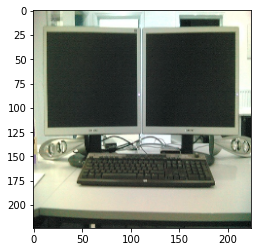

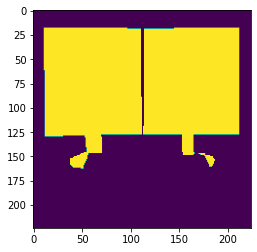

In [0]:
# Visualize samples of the training batch; images and labels:

plt.figure()
plt.imshow(train_images[4])
plt.show() 
plt.imshow(train_labels[4])

Tranfsorm the lables to One-Hot encoded vectors:

In [0]:
from keras.utils import to_categorical
y_trn= to_categorical(train_labels, num_classes=21)
y_val= to_categorical(val_labels, num_classes=21)

Using TensorFlow backend.


# Our VGG16 model:

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))


In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
from keras import models
from keras import layers
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from matplotlib import pyplot
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, Input, UpSampling2D, Dense, Conv2D, MaxPooling2D, Reshape, BatchNormalization, Activation, Conv2DTranspose, Add, ZeroPadding2D, Cropping2D
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, SGD

num_classes = 21
model = Sequential()
conv_base.trainable = False
model.add(conv_base)
#model.add(layers.Flatten())
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dense(224*224, activation='sigmoid'))     # We expect an output that is a 224*224 picture which has the same dimension as the labelled data

model.add(Conv2D(4096, (7, 7), activation='relu',padding='same')) # Conv layer 6
model.add((Conv2D(4096, (1, 1), activation='relu',padding='same'))) # Conv layer 6
model.add(Conv2D(num_classes,  (1, 1), kernel_initializer='he_normal',padding='valid'))
# model.add(Conv2DTranspose(num_classes, kernel_size=(32, 32),  strides=(32, 32), use_bias=False))
model.add(UpSampling2D(size=(32, 32), data_format=None, interpolation='nearest')) # Upsampling


In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 4096)        102764544 
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 4096)        16781312  
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 21)          86037     
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 224, 224, 21)      0         
Total params: 134,346,581
Trainable params: 119,631,893
Non-trainable params: 14,714,688
_________________________________________________________________


We need to add a final operation that shrinks the output over the third dimension so that its size is just: 224x224

Note: The pixel values of the output would represent the maximum value of the pixels along this 3rd dimension. Furthermore, the values will lie between 0 & 21 corressponding to the different classes

We will do so manually by creating a keras layer class that does this job.

In [0]:
from keras import backend as K
from keras.layers import Layer

class argmaxLayer(Layer):
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2])

    def call(self, inputs):
        return K.argmax(inputs, axis=3)

In [0]:
# We can check that this layer works properly on a random object that matches the output of our network.. shape=(None,x,y,z):
x = ([(1,1,1), (1,2,3)],[(1,1,7), (0,1,0)])
x = np.expand_dims(x, axis=0)
print("The shape of the input is:", np.array(x).shape)
print("The following is the result of the argmax numpy function:\n", np.argmax(x, axis=3))

output = argmaxLayer()(K.constant(x))
print("The following is the result of the argmaxLayer operation:\n", K.eval(output))

The shape of the input is: (1, 2, 2, 3)
The following is the result of the argmax numpy function:
 [[[0 2]
  [2 1]]]
The following is the result of the argmaxLayer operation:
 [[[0 2]
  [2 1]]]


So, now we safely add this argmaxLayer to our model. The following is the update summary of the model.

In [0]:
model.add(argmaxLayer())
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 4096)        102764544 
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 4096)        16781312  
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 21)          86037     
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 224, 224, 21)      0         
_________________________________________________________________
argmax_layer_4 (argmaxLayer) (None, 224, 224)          0         
Total params: 134,346,581
Trainable params: 119,631,893
Non-trainable params: 14,714,688
_______________________________

It is clear now that the output dimensions matches the dimensions of the labelled data.

It is also clear that this final layer we added will not have any trainable parameters. This makes sense because it is just an argmax operation that reduces the 3rd rank tensor to 2nd rank.

# Training:

In [0]:
opt = SGD(lr=0.001, momentum=0.9)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']
epochs = 50
steps_per_epoch = 100
model.compile(optimizer=opt, loss=loss, metrics=metrics)
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=epochs, verbose=True, batch_size=100)

ValueError: ignored